In [1]:
import glob
import json
import pandas as pd
import datetime
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
# gets every log from directory
all_logs = glob.glob("logs/*.json")
print(len(all_logs))

598


In [3]:
# formats all logs properly 
# key = session ID
# value = json w/ same format as what was originally held in nb metadata
formatted_logs = {}

for log in all_logs:
    f = open(log, 'r')
    if log == 'logs/0330c0848a8873feb20b5b8af2dc3ae6undefined.json':
        print(log)
        print(f.read())
    # merges body sent from various HTTP Posts
#     print(f.read())
    entries = f.read().split('}{')
#     print(entries[0])
    for i in range(len(entries)):
        entries[i] = '{' + entries[i] + '}'
    entries[0] = entries[0][1:]
    entries[-1] = entries[-1][:-1]
#     print(entries[0])
    formatted_log = json.loads(entries[0])
    for i in range(1,len(entries)):
        j = json.loads(entries[i])
        history = j['history']
        formatted_log['history'].extend(history)
    
    # get time user started ipynb
    formatted_log['startTime'] = formatted_log['history'][0]['time']
    formatted_log['endTime'] = formatted_log['history'][len(formatted_log['history'])-1]['time']
    
    # separates user hash from file name (sessionID)
    names = log.split('_')
    formatted_log['userHash'] = names[0][5:]
    
    # excluding Jerry and Doris and potentially others
    exclude_list = ['bca87887a1cc89312f7d073fd007ea68', '1a735d0ee6a6f9d7fdab573b50851da7']
    if names[0][5:] not in exclude_list:
        formatted_logs[names[1][:-5]] = formatted_log


In [4]:
len(formatted_logs)

477

In [5]:
df = pd.DataFrame(formatted_logs).transpose().sort_values('userHash')

In [6]:
df

,nbName,history,startTime,endTime,userHash
czxswqqjy,1-specifying-intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T02:41:41.804Z,2020-12-27T03:01:14.187Z,003724cc5e41a981d3fad0ca3f21888d
6b6nhxtxh,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T01:20:56.927Z,2020-12-27T01:47:49.232Z,003724cc5e41a981d3fad0ca3f21888d
8pzgwyy22,1-specifying-intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T03:02:30.953Z,2020-12-27T03:12:26.956Z,003724cc5e41a981d3fad0ca3f21888d
ug7hr39o8,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-30T05:36:43.016Z,2020-11-30T06:11:08.975Z,003a65e7008e9f7db64a6559970f962c
97vczg8cn,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-03T02:55:46.498Z,2020-12-03T03:12:19.732Z,006b045214badd8a59f7f11c1eae488c
...,...,...,...,...,...
f1ukitdr9,1-Specify-Intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04T21:34:36.099Z,2020-11-04T21:47:49.607Z,fc836b6c537cc69b6eb6ab9cb7cb6b05
ku8fm3jm6,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04T21:56:31.543Z,2020-11-04T22:14:47.763Z,fc836b6c537cc69b6eb6ab9cb7cb6b05
o995ki32j,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-01T06:17:35.472Z,2020-12-01T06:34:09.014Z,fe50a4ea1e132d4d505b7941f1f48ef0
jiklvm3yu,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-25T16:37:15.015Z,2020-12-25T17:06:12.739Z,feba0e7c024be16c21b46a6257a10367


In [7]:
# Number of unique IPs data was sent from
df['userHash'].nunique()

310

In [8]:
# Creates userGroups based on when notebook was first used
def groupDate(x):
    if x['startTime'].date() <= datetime.date(2020, 11, 1):
        return 'RiseCamp'
    elif x['startTime'].date() > datetime.date(2020, 11, 3) and x['startTime'].date() <= datetime.date(2020, 11, 5):
        return 'USF'
    else:
        return 'Other'
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])
df['userGroup'] = df.apply(groupDate, axis=1)
df = df.sort_values('startTime')

In [9]:
df.sort_values('userGroup')

,nbName,history,startTime,endTime,userHash,userGroup
4wirrulrw,0-overview.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-01 15:34:34.845000+00:00,2020-12-01 15:37:52.896000+00:00,200919f12a8ed20669ce2166d9c24530,Other
6rnmory2o,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-08 22:03:54.602000+00:00,2020-12-08 22:04:01.618000+00:00,324cf58e404d277827091ccaf56bba99,Other
7dtoihteg,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-08 06:49:10.098000+00:00,2020-12-08 06:51:09.017000+00:00,77f91d3c5bf083e9853822321610ffeb,Other
24wybqbtc,4-chart-settings.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-07 20:18:02.166000+00:00,2020-12-07 20:18:02.166000+00:00,1f3de656a45930f32a169f2ce8df6934,Other
qrog5bnzu,cars_demo.ipynb,"[{'type': 'selectCodeCell', 'time': '2020-12-0...",2020-12-07 20:14:28.310000+00:00,2020-12-07 20:14:33.180000+00:00,43325b9982f800c4b34f9b1be0dc39b2,Other
...,...,...,...,...,...,...
2b21sgaq4,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:52:03.810000+00:00,2020-11-04 22:06:27.297000+00:00,c970dc2661f9bafca1c9f7c959e5fcde,USF
m2xc6ec08,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:52:17.359000+00:00,2020-11-04 22:01:28.290000+00:00,52dacd9e8e026c076c886a89c4a84b9a,USF
q7onw2fq2,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:53:17.697000+00:00,2020-11-04 22:06:48.111000+00:00,aea7f8e69322a459e5639238c290c57e,USF
2gqzflfxq,3-Export-Widget.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:58:24.082000+00:00,2020-11-04 21:58:30.376000+00:00,52dacd9e8e026c076c886a89c4a84b9a,USF


In [10]:
nb_map = {}
nbs = df[df['userGroup'] == 'Other']
for nb in nbs['nbName']: 
    if nb in nb_map:
        nb_map[nb] += 1
    else:
        nb_map[nb] = 1
nb_map

{'2-Quick-Vis.ipynb': 6,
 'cars_demo.ipynb': 276,
 '1-Specify-Intent.ipynb': 4,
 '1-specifying-intent.ipynb': 13,
 '3-widget-vis-export.ipynb': 7,
 '4-chart-settings.ipynb': 6,
 '5-datetime.ipynb': 10,
 '7-formal-definition.ipynb': 4,
 '0-overview.ipynb': 24,
 '6-index-group.ipynb': 5,
 'college_demo.ipynb': 6,
 '.ipynb': 1,
 '4-Data-Playground.ipynb': 3,
 '3-Export-Widget.ipynb': 2,
 '2-constructing-vis-and-vislist.ipynb': 5,
 '8-custom-action.ipynb': 1,
 'exploratory_demo.ipynb': 3,
 'penguin_demo.ipynb': 4,
 'employee_demo.ipynb': 8}

In [11]:
len(nbs)

388

In [12]:
diff = nbs['endTime'] - nbs['startTime']
diff = [x.total_seconds()%3600 / 60 for x in diff]

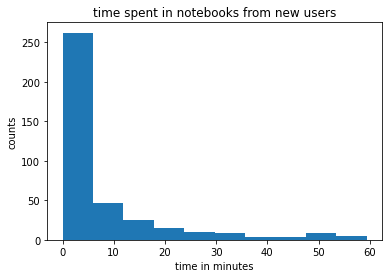

In [13]:
plt.hist(diff)
plt.xlabel("time in minutes")
plt.ylabel('counts')
plt.title('time spent in notebooks from new users')
plt.show()



In [14]:
def has_0(nbNames):
    for nbName in nbNames:
        if '0' in nbName:
            return 1
    return 0
def has_1(nbNames):
    for nbName in nbNames:
        if '1' in nbName:
            return 1
    return 0
def has_2(nbNames):
    for nbName in nbNames:
        if '2' in nbName:
            return 1
    return 0
def has_3(nbNames):
    for nbName in nbNames:
        if '3' in nbName:
            return 1
    return 0
def has_4(nbNames):
    for nbName in nbNames:
        if '4' in nbName:
            return 1
    return 0

In [15]:
# Groups users by hash and computes information as to whether user attempt notebook
grouped_df = df.groupby('userHash').agg(userGroup=('userGroup', sp.mode), startTime=('startTime', 'min'), endTime=('endTime', 'max'), 
                                        tried_0=('nbName', has_0), tried_1=('nbName', has_1), tried_2=('nbName', has_2),
                                        tried_3=('nbName', has_3), tried_4=('nbName', has_4))
grouped_df['userGroup'] = grouped_df['userGroup'].apply(lambda x: x[0][0])
grouped_df.sort_values('startTime')

,userGroup,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userHash,,,,,,,,
e0157f975b2aecbe652c4706db61a112,RiseCamp,2020-10-30 20:50:55.802000+00:00,2020-11-13 03:27:19.899000+00:00,1,1,1,1,1
46c3fa396f1071a92372dc40078b42f0,RiseCamp,2020-10-30 21:23:52.207000+00:00,2020-10-30 22:28:26.332000+00:00,0,1,1,1,0
a8c4ac0672f0751b58b4738ef4488877,RiseCamp,2020-10-30 21:36:27.644000+00:00,2020-10-30 22:29:35.339000+00:00,0,1,1,1,1
8ad0735d692b120e07de75cb96440fa3,RiseCamp,2020-10-30 21:40:35.290000+00:00,2020-11-02 18:28:19.854000+00:00,1,1,0,1,1
3ea0843857adef1f9fd1734eb9c0a562,RiseCamp,2020-10-30 21:44:23.298000+00:00,2020-10-30 22:29:35.556000+00:00,0,1,1,1,1
...,...,...,...,...,...,...,...,...
3b6617e83c75584d167fbe0bc90211b0,Other,2021-02-20 17:17:16.629000+00:00,2021-02-20 17:18:15.736000+00:00,0,0,0,0,0
dd9a7bec7682e860a03e46de3fd87bb6,Other,2021-02-22 01:06:51.151000+00:00,2021-02-22 01:20:55.006000+00:00,0,0,0,0,0
1e42ea0b9d7d5e8a333801eb24931209,Other,2021-02-22 09:27:02.064000+00:00,2021-02-22 09:35:29.254000+00:00,0,0,0,0,0


In [16]:
grouped_df.groupby("userGroup").count()

,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userGroup,,,,,,,
Other,288,288,288,288,288,288,288
RiseCamp,11,11,11,11,11,11,11
USF,11,11,11,11,11,11,11


In [17]:
# Plots user attemps at tutorial notebooks
def plot_nb_progression(df, userGroup, n):
    nbNames = ['1-Specify-Intent.ipynb', '2-Quick-Vis.ipynb', '3-widget-vis-export.ipynb', '4-Data-Playground.ipynb'] 
    counts = [sum(df['tried_1']),sum(df['tried_2']),sum(df['tried_3']),sum(df['tried_4'])]
    plt.bar(nbNames , counts)
    plt.xticks(nbNames, rotation=45)
    plt.title(str(userGroup) + ' Attempts of Tutorial Notebooks n=' + str(n))
    plt.ylabel('Counts')
    plt.show()


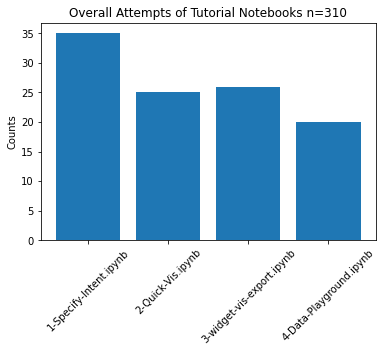

In [18]:
plot_nb_progression(grouped_df, 'Overall', len(grouped_df))

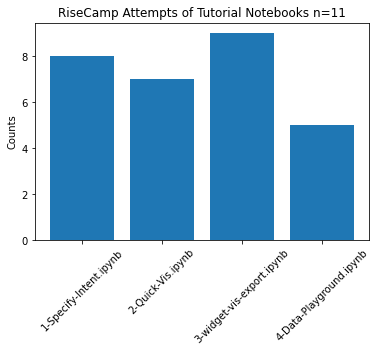

In [19]:
riseCamp_df = grouped_df[grouped_df['userGroup']=='RiseCamp']
plot_nb_progression(riseCamp_df, 'RiseCamp', len(riseCamp_df))

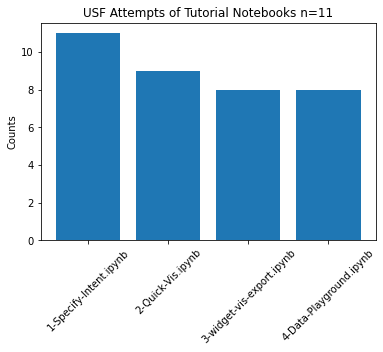

In [20]:
usf_df = grouped_df[grouped_df['userGroup']=='USF']
plot_nb_progression(usf_df, 'USF', len(usf_df))

In [21]:
# playground_df = df[df['nbName'] == '4-Data-Playground.ipynb']
playground_df = df

[{'type': 'executeCodeCell', 'time': '2021-02-20T03:33:20.938Z', 'code': 'import pandas as pd\nimport lux\n# Collecting basic usage statistics for Lux (For more information, see: https://tinyurl.com/logging-consent)\nlux.logger = True # Remove this line if you do not want your interactions recorded', 'id': 'b0695c50052d40c28816ae63ef8c77b0', 'order_count': 5}, {'type': 'completeCodeCell', 'time': '2021-02-20T03:33:28.274Z', 'code': "df = pd.read_csv('../data/penguins.csv')", 'id': '163895b51f364d2d8ef3cea6df058628', 'isPrintPandasDf': False, 'isPrintLuxDf': False, 'isPrintVis': False, 'isPrintVisCollection': False, 'order_count': 6}, {'type': 'selectCodeCell', 'time': '2021-02-20T03:33:31.100Z', 'code': 'df.info()', 'id': 'c324a5349916472286ad64b2a8ef4886', 'order_count': 8}, {'type': 'executeCodeCell', 'time': '2021-02-20T03:33:31.552Z', 'code': 'df.info()', 'id': 'c324a5349916472286ad64b2a8ef4886', 'order_count': 8}, {'type': 'completeCodeCell', 'time': '2021-02-20T03:33:31.840Z', 'c

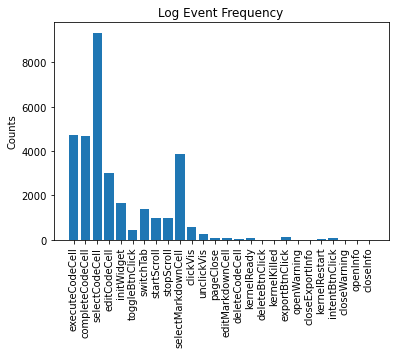

In [47]:
# takes care of scrolling issue where if they stop scrolling for a moment, it treats as separate scrolls

function_freq = {}
timing = {}
for log in playground_df['history']:
    prev = ''
    for entry in log:
        if 'type' in entry.keys():
            if 'stopScroll' not in prev:
                if entry['type'] in function_freq.keys():
                    function_freq[entry['type']] += 1
                else:
                    function_freq[entry['type']] = 1
            prev = entry['type']
        else:
            print(log)
        
function_freq['stopScroll'] = function_freq['startScroll']
function_freq['initWidget'] = function_freq['initWidget']/2
# del function_freq['selectCodeCell']
plt.bar(function_freq.keys(), function_freq.values())
plt.xticks(list(function_freq.keys()), rotation=90)
plt.title('Log Event Frequency')
plt.ylabel('Counts')
plt.show()
        

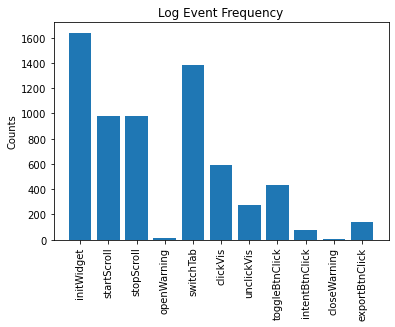

In [31]:
lux_events = ['initWidget', 'startScroll', 'stopScroll', 'openWarning', 'switchTab', 'clickVis', 'unclickVis', 'toggleBtnClick', 'intentBtnClick', 'closeWarning', 'exportBtnClick']
lux_values = []
for event in lux_events:
    lux_values.append(function_freq[event])
    
plt.bar(lux_events, lux_values)
plt.xticks(lux_events, rotation=90)
plt.title('Log Event Frequency')
plt.ylabel('Counts')
plt.show()
          

In [32]:
playground_df['endTime'] - playground_df['startTime']

9ixn8fst1   13 days 06:36:24.097000
czs122fic    0 days 01:04:34.125000
sg8cq2mmb    0 days 00:52:02.763000
0qocq99zz    0 days 00:15:17.128000
txodzcfin    2 days 20:47:44.451000
                      ...          
8q8ohu1o0    0 days 00:00:59.107000
xyvxlzdlc    0 days 00:14:03.855000
kgcp5p4gr    0 days 00:08:27.190000
yzcb56im4    0 days 00:19:54.735000
upk8v5eo2    0 days 00:00:27.113000
Length: 477, dtype: timedelta64[ns]

In [33]:
grouped_df.reset_index().drop(columns=["startTime","endTime"]).to_csv("user_groups.csv",index=None)

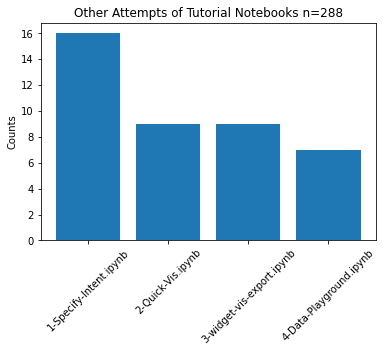

In [34]:
other_df = grouped_df[grouped_df['userGroup']=='Other']
plot_nb_progression(other_df, 'Other', len(other_df))

In [35]:
other_df

,userGroup,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userHash,,,,,,,,
003724cc5e41a981d3fad0ca3f21888d,Other,2020-12-27 01:20:56.927000+00:00,2020-12-27 03:12:26.956000+00:00,0,1,0,0,0
003a65e7008e9f7db64a6559970f962c,Other,2020-11-30 05:36:43.016000+00:00,2020-11-30 06:11:08.975000+00:00,0,0,0,0,0
006b045214badd8a59f7f11c1eae488c,Other,2020-12-03 02:55:46.498000+00:00,2020-12-03 03:12:19.732000+00:00,0,0,0,0,0
00ae885f453834201f83376bcfddd31a,Other,2020-11-30 07:02:30.883000+00:00,2020-11-30 07:02:53.966000+00:00,0,0,0,0,0
040b920fcc03cbc13e159b961d57263f,Other,2020-12-01 08:39:38.863000+00:00,2020-12-01 08:53:22.688000+00:00,0,0,0,0,0
...,...,...,...,...,...,...,...,...
f920d5c664474a7f2b0e4aef22dc1e60,Other,2020-12-24 13:18:46.572000+00:00,2020-12-24 13:41:37.082000+00:00,0,0,0,0,0
f9f880ad977d9c674f4eddb31fde8bc3,Other,2020-11-30 10:30:26.448000+00:00,2020-11-30 10:31:21.925000+00:00,0,0,0,0,0
fe50a4ea1e132d4d505b7941f1f48ef0,Other,2020-12-01 06:17:35.472000+00:00,2020-12-01 06:34:09.014000+00:00,0,0,0,0,0


## Computing Time until Toggle and Time in Each Tab

In [36]:
df['history'][1]

[{'type': 'executeCodeCell',
  'time': '2020-10-30T21:23:52.207Z',
  'code': '# Collecting basic usage statistics for Lux (For more information, see: https://tinyurl.com/logging-consent)\nlux.logger = True # Remove this line if you do not want your interactions recorded',
  'id': '7ff680bd2c2c46449215062d7823d83d',
  'order_count': 3},
 {'type': 'selectCodeCell',
  'time': '2020-10-30T21:23:52.223Z',
  'code': 'df = pd.read_csv("../data/college.csv")\nlux.config.default_display = "lux" # Setting default display as Lux',
  'id': '45b878b91fd340d488e0684a886af5ec',
  'order_count': 4},
 {'type': 'completeCodeCell',
  'time': '2020-10-30T21:23:52.228Z',
  'code': '# Collecting basic usage statistics for Lux (For more information, see: https://tinyurl.com/logging-consent)\nlux.logger = True # Remove this line if you do not want your interactions recorded',
  'id': '7ff680bd2c2c46449215062d7823d83d',
  'isPrintPandasDf': False,
  'isPrintLuxDf': False,
  'isPrintVis': False,
  'isPrintVisCo

In [61]:
def get_toggles(history):
    count = 0
    for entry in history:
        if 'type' in entry.keys() and entry['type'] == 'initWidget':
            count += 1
    return count // 2

def get_times_until_toggle(history):
    times = []
    for i in range(len(history)):
        if 'type' in history[i].keys() and history[i]['type'] == 'initWidget' and history[i-1]['type'] == 'initWidget':
            j=i-2
            while j>=0:
                if history[j]['type'] != 'completeCodeCell':
                    j-=1
                elif history[j]['isPrintPandasDf'] != True:
                    j-=1
                else:
                    break
            if j != -1:
                timeDiff = pd.to_datetime(history[i-1]['time']) - pd.to_datetime(history[j]['time'])
                times.append(timeDiff.total_seconds())
    return times

def get_first_switch_time(history):
    times = []
    for i in range(len(history)):
        if 'type' in history[i].keys() and history[i]['type'] == 'initWidget' and history[i-1]['type'] == 'initWidget':
            j=i+1
            while j<len(history) and history[j]['type'] != 'switchTab':
                j+=1
            if j < len(history):
                timeDiff = pd.to_datetime(history[j]['time']) - pd.to_datetime(history[i-1]['time'])
                times.append(timeDiff.total_seconds())
    return times

In [62]:
df['initWidgetCount'] = df['history'].apply(get_toggles)
df['timeUntilWidgitInit'] = df['history'].apply(get_times_until_toggle)
df['timeUntilFirstSwitchTab'] = df['history'].apply(get_first_switch_time)

In [63]:
time_df = df[['nbName','history','userGroup','initWidgetCount', 'timeUntilWidgitInit', 'timeUntilFirstSwitchTab']]
time_df

,nbName,history,userGroup,initWidgetCount,timeUntilWidgitInit,timeUntilFirstSwitchTab
9ixn8fst1,0-overview.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,4,"[11.329, 15.343, 30.185, 153.001]","[25.172, 21.158, 6.316]"
czs122fic,1-Specify-Intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,8,[],"[18.688, 149.649, 144.711, 25.378, 56.075, 32...."
sg8cq2mmb,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,11,"[1.907, 2.536]",[]
0qocq99zz,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,12,"[3.743, 5.973, 1.928, 8.235, 10.525, 13.778, 1...","[8.652, 9.394, 13.909, 3.6, 1.31]"
txodzcfin,0-Lux-Overview.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,3,"[2.099, 2.875, 4.029]","[459.798, 239.331, 14.536]"
...,...,...,...,...,...,...
8q8ohu1o0,employee_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,1,[],[]
xyvxlzdlc,employee_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,3,"[37.6, 52.361, 61.124]",[]
kgcp5p4gr,employee_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,2,"[38.385, 41.265]","[13.907, 11.027]"
yzcb56im4,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,7,"[42.267, 63.762, 128.48, 144.077, 2.049]","[113.052, 91.557, 26.839, 11.242]"


In [67]:
time_df.to_csv("ToggleAndSwitchTimesCorrected.csv")

In [ ]:
sum(df['initWidgetCount']) / len(df['initWidgetCount'])

In [ ]:
def get_avg_non_zero(lst):
    count = 0
    total = 0
    for elem in lst:
        if elem != 0:
            count += 1
            total += elem
    return total/count

In [ ]:
widgitInit = list(np.concatenate(df['timeUntilWidgitInit']).flat)
print(sum(widgitInit) / len(widgitInit))
print(get_avg_non_zero(widgitInit))

In [ ]:
print(np.percentile(widgitInit, 90))

In [ ]:
switchTimes = list(np.concatenate(df['timeUntilFirstSwitchTab']).flat)
print(get_avg_non_zero(switchTimes))


In [ ]:
plt.figure(figsize=(1, 5))
plt.boxplot(df['initWidgetCount'])
plt.ylabel("Number of Widget Inits")
plt.show()

In [ ]:
non_zero = list(filter(lambda x: x!=0, widgitInit))
non_zero_truncated = list(filter(lambda x: x < 200, non_zero))
plt.figure(figsize=(5, 3))
plt.hist(non_zero_truncated)
plt.xlabel("Time Until Widgit Init")
plt.ylabel("Count")
plt.show()

In [ ]:
truncated_widgit_init = list(filter(lambda x: x != 0 and x < 3*np.std(widgitInit), widgitInit))
plt.figure(figsize=(1, 5))
plt.hist(truncated_widgit_init)
plt.ylabel("Time Until Init Widget")
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))
truncated_switchTimes = list(filter(lambda x: x < 200, switchTimes))
plt.hist(truncated_switchTimes)
plt.xlabel("Time Until First Tab Switch")
plt.ylabel("Count")
plt.show()